In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# Splitting a grid into cardinal quarters

In [3]:
n = 18
shape = np.array([n,n])

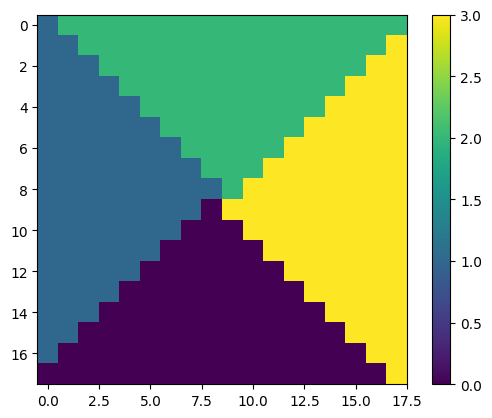

In [4]:
array = np.zeros(shape)
center = ((shape-1) / 2)

# Finding indices
indices_list = list(np.ndindex(array.shape))
indices_array = np.array(indices_list)

# From the indices finding the points and converting them to the imaginary grid
points = indices_array - center
points_im = points[:,0] + (points[:,1] * 1j)

# Shifting the points by 4 times by 90degrees and computing the angles
shifted_points_im = points_im[:,None] * np.array([1, 1j, -1, -1j])
angles = np.angle(shifted_points_im, deg=True)

# Computing the closest quarter for each point and assigning it on the grid
closest_quarter = np.argmin(np.abs(angles) + np.where(angles < 0, 0, 1), axis=1)
array[*indices_array.T] = closest_quarter

# Plot results
plt.imshow(array)
plt.colorbar()
plt.show()

# Splitting space from an amount of subdivisions

In [5]:
# ! Fixed variables
space_shape = np.array([101,101])
cells = np.array([3,3])

# Source
source_position = np.array([33,33])
source_radius = 4

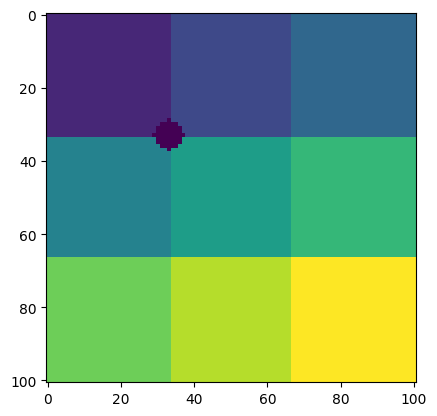

In [6]:
# Finding the sizes of the cells
cell_size_standard = (space_shape / cells).astype(int)
cell_size_overflow = (space_shape % cells).astype(int)

# Determining cell sizes
cell_sizes = []
for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
    sizes = np.repeat(ax_size, ax_cells)
    sizes[:int(np.floor(ax_overflow/2))] += 1
    sizes[-int(np.ceil(ax_overflow/2)):] += 1
    cell_sizes.append(sizes)

# Finding the edges of the cells and filling a grid with ids
cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

grid_cells = np.full(space_shape, -1)
for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
    slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

    # Grid to cell mapping
    grid_cells[*slices] = i

# Finding cell the replace
source_cell_id = grid_cells[*source_position]
source_cell = np.array(np.unravel_index(source_cell_id, cells))

# Finding center and replacing with closest side
source_cell_shape = np.array([sizes[int(ax_id)] for sizes, ax_id in zip(cell_sizes, source_cell)])
source_in_source_cell = source_position - lower_bounds[source_cell_id]

# Splitting the center cell grid into cardinal quarters
array = np.zeros(source_cell_shape)

# Finding indices
indices_list = list(np.ndindex(array.shape))
indices_array = np.array(indices_list)

# From the indices finding the points and converting them to the imaginary grid
points = indices_array - source_in_source_cell
points_im = points[:,0] + (points[:,1] * 1j)

# Shifting the points by 4 times by 90degrees and computing the angles
shifted_points_im = points_im[:,None] * np.array([1, 1j, -1, -1j])
angles = np.angle(shifted_points_im, deg=True)

# # Finding edge cells
edge_cells = source_cell[None,:] + np.array([[1,0],[0,-1],[-1,0],[0,1]])
edge_exists = np.all((edge_cells >= 0) & (edge_cells < cells), axis=1)
edge_cells[~edge_exists] = source_cell[None,:]
edge_cells_id = np.ravel_multi_index(edge_cells.T, cells)

# Computing the closest quarter for each point and assigning it on the grid
closest_quarter = np.argmin(np.abs(angles) + np.where(angles < 0, 0, 1), axis=1)
array[*indices_array.T] = edge_cells_id[closest_quarter]
# array[*indices_array.T] = (np.arange(4) + np.prod(cells))[closest_quarter]

# Inserting in the grid
source_cell_slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_bounds[source_cell_id], upper_bounds[source_cell_id])]
grid_cells[*source_cell_slices] = array

# Spacial indices
spacial_indices = list(np.ndindex(tuple(space_shape)))
spacial_indices_array = np.array(spacial_indices).astype(int)

# Indices are at source
at_source = np.sum((source_position[None,:] - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
grid_cells[*spacial_indices_array[at_source].T] = -1


# Plot results
plt.imshow(grid_cells)
plt.show()

# Building it into a function

In [7]:
def build_grid_mapping(space_shape: np.ndarray = np.array([101,101]),
                       cells: np.ndarray = np.array([3,3]),
                       source_position: np.ndarray = np.array([50,50]),
                       source_radius: int = 4
                       ) -> np.ndarray:
    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T
    upper_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[1 :] for bounds_arr in cell_edges], indexing='ij')]).T

    grid_cells = np.full(space_shape, -1)
    for i, (lower_b, upper_b) in enumerate(zip(lower_bounds, upper_bounds)):
        slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_b, upper_b)]

        # Grid to cell mapping
        grid_cells[*slices] = i

    # Finding cell the replace
    source_cell_id = grid_cells[*source_position]
    source_cell = np.array(np.unravel_index(source_cell_id, cells))

    # Finding center and replacing with closest side
    source_cell_shape = np.array([sizes[int(ax_id)] for sizes, ax_id in zip(cell_sizes, source_cell)])
    source_in_source_cell = source_position - lower_bounds[source_cell_id]

    # Splitting the center cell grid into cardinal quarters
    array = np.zeros(source_cell_shape)

    # Finding indices
    indices_list = list(np.ndindex(array.shape))
    indices_array = np.array(indices_list)

    # From the indices finding the points and converting them to the imaginary grid
    points = indices_array - source_in_source_cell
    points_im = points[:,0] + (points[:,1] * 1j)

    # Shifting the points by 4 times by 90degrees and computing the angles
    shifted_points_im = points_im[:,None] * np.array([1, 1j, -1, -1j])
    angles = np.angle(shifted_points_im, deg=True)

    # # Finding edge cells
    edge_cells = source_cell[None,:] + np.array([[1,0],[0,-1],[-1,0],[0,1]])
    edge_exists = np.all((edge_cells >= 0) & (edge_cells < cells), axis=1)
    edge_cells[~edge_exists] = source_cell[None,:]
    edge_cells_id = np.ravel_multi_index(edge_cells.T, cells)

    # Computing the closest quarter for each point and assigning it on the grid
    closest_quarter = np.argmin(np.abs(angles) + np.where(angles < 0, 0, 1), axis=1)
    array[*indices_array.T] = edge_cells_id[closest_quarter]
    # array[*indices_array.T] = (np.arange(4) + np.prod(cells))[closest_quarter]

    # Inserting in the grid
    source_cell_slices = [slice(ax_lower, ax_upper) for ax_lower, ax_upper in zip(lower_bounds[source_cell_id], upper_bounds[source_cell_id])]
    grid_cells[*source_cell_slices] = array

    # Spacial indices
    spacial_indices = list(np.ndindex(tuple(space_shape)))
    spacial_indices_array = np.array(spacial_indices).astype(int)

    # Indices are at source
    at_source = np.sum((source_position[None,:] - spacial_indices_array) ** 2, axis=1) <= source_radius ** 2
    grid_cells[*spacial_indices_array[at_source].T] = -1

    return grid_cells

In [8]:
grid_cells = build_grid_mapping()

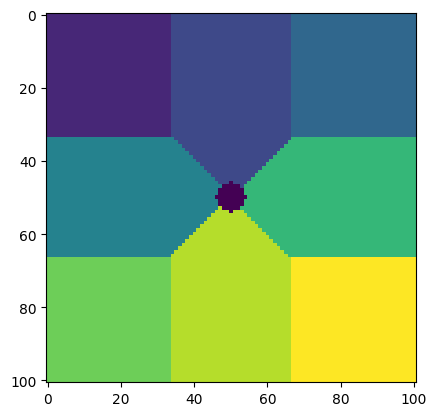

In [9]:
plt.imshow(grid_cells)

# Transitions

In [61]:
def find_cell_centers(space_shape: np.ndarray = np.array([101,101]),
                      cells: np.ndarray = np.array([3,3])):

    # Finding the sizes of the cells
    cell_size_standard = (space_shape / cells).astype(int)
    cell_size_overflow = (space_shape % cells).astype(int)

    # Determining cell sizes
    cell_sizes = []
    for ax_cells, ax_size, ax_overflow in zip(cells, cell_size_standard, cell_size_overflow):
        sizes = np.repeat(ax_size, ax_cells)
        sizes[:int(np.floor(ax_overflow/2))] += 1
        sizes[-int(np.ceil(ax_overflow/2)):] += 1
        cell_sizes.append(sizes)

    # Finding the edges of the cells and filling a grid with ids
    cell_edges = [np.concatenate(([0], np.cumsum(ax_sizes))) for ax_sizes in cell_sizes]

    lower_bounds = np.array([ax_arr.ravel() for ax_arr in np.meshgrid(*[bounds_arr[:-1] for bounds_arr in cell_edges], indexing='ij')]).T

    cell_centers = lower_bounds + np.floor(cell_size_standard / 2).astype(int)
    return cell_centers

In [83]:
# Fixed variables
space_shape = np.array([101,101])
cells = np.array([3,3])
source_radius = 4

moves = np.array([
    [-1,  0], # North
    [ 0,  1], # East
    [ 1,  0], # South
    [ 0, -1]  # West
])

In [161]:
source_positions = find_cell_centers(space_shape=space_shape,
                                     cells=cells)

# Spacial indices
spacial_indices = list(np.ndindex(tuple(space_shape)))
spacial_indices_array = np.array(spacial_indices).astype(int)

# Set the transition probability matrix
cell_count = np.prod(cells)
state_count = (cell_count**2) + 1
action_count = len(moves)
transition_probabilities = np.zeros((state_count, action_count, state_count))

for source_i, source_pos in enumerate(source_positions):
    grid_cells = build_grid_mapping(space_shape=space_shape,
                                    cells=cells,
                                    source_position=source_pos,
                                    source_radius=source_radius)
    cells_from_indices = grid_cells[*spacial_indices_array.T]

    move_probabilities = []
    for move in moves:
        # Applying the moves to the indices
        moved_indices = spacial_indices_array + move
        moved_indices_clipped = np.clip(moved_indices, 0, space_shape-1)

        # Converting moved indices to cell indices
        cells_from_indices_after_move = grid_cells[*moved_indices_clipped.T]

        # Building a confusion matrix of the moves
        conf = confusion_matrix(cells_from_indices, cells_from_indices_after_move, labels=[-1] + list(np.arange(np.prod(cells))), normalize='true')
        move_probabilities.append(conf[:,None,:])

    # Stack probabilities
    move_probabilities = np.hstack(move_probabilities)

    # In case a cell is not used, make the transition loop on itself
    zero_move_probabilities = np.argwhere(move_probabilities.sum(axis=-1) == 0).T
    move_probabilities[zero_move_probabilities[0], zero_move_probabilities[1], zero_move_probabilities[0]] = 1.0

    # Set the values in the transition matrix
    source_slice = slice((source_i * cell_count), ((source_i + 1) * cell_count))
    transition_probabilities[source_slice, :, source_slice] = move_probabilities[1:,:,1:]
    transition_probabilities[source_slice, :, -1] = move_probabilities[1:,:,0]
    transition_probabilities[-1, :, -1] = 1.0

assert np.all(transition_probabilities.sum(axis=-1).round(8) == 1.0)